# Monster Classification

Welcome! </br> In this notebook, we will explore a dataset of monsters and use various machine learning techniques to predict their types (Ghoul, Goblin, or Ghost) based on their physical characteristics. We'll start with data exploration and visualization, engineer new features, and then build and evaluate several classification models.


In [1]:
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.pipeline import Pipeline
import warnings
warnings.filterwarnings('ignore')

**Result Sample** </br> 
This is what we should provide as a result.

In [2]:
# import databases
sample = pd.read_csv("/kaggle/input/monsters-dataset-unzip/sample_submission.csv")
sample.head()

,id,type
0,3,Ghost
1,6,Ghost
2,9,Ghost
3,10,Ghost
4,13,Ghost


**Test Data** </br>
Will be used to test the model

In [3]:
test = pd.read_csv("/kaggle/input/monsters-dataset-unzip/test.csv")
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 529 entries, 0 to 528
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             529 non-null    int64  
 1   bone_length    529 non-null    float64
 2   rotting_flesh  529 non-null    float64
 3   hair_length    529 non-null    float64
 4   has_soul       529 non-null    float64
 5   color          529 non-null    object 
dtypes: float64(4), int64(1), object(1)
memory usage: 24.9+ KB


**Train Data** </br> This is the set we gonna work on

In [4]:
train = pd.read_csv("/kaggle/input/monsters-dataset-unzip/train.csv")
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 371 entries, 0 to 370
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             371 non-null    int64  
 1   bone_length    371 non-null    float64
 2   rotting_flesh  371 non-null    float64
 3   hair_length    371 non-null    float64
 4   has_soul       371 non-null    float64
 5   color          371 non-null    object 
 6   type           371 non-null    object 
dtypes: float64(4), int64(1), object(2)
memory usage: 20.4+ KB


## EDA

**Data fields:**
- id - id of the creature
- bone_length - average length of bone in the creature, normalized between 0 and 1
- rotting_flesh - percentage of rotting flesh in the creature
- hair_length - average hair length, normalized between 0 and 1
- has_soul - percentage of soul in the creature
- color - dominant color of the creature: 'white','black','clear','blue','green','blood'
- type - target variable: 'Ghost', 'Goblin', and 'Ghoul'

In [5]:
print("\nNumerical Features Statistics:")
train.describe()


Numerical Features Statistics:


,id,bone_length,rotting_flesh,hair_length,has_soul
count,371.000000,371.000000,371.000000,371.000000,371.000000
mean,443.676550,0.434160,0.506848,0.529114,0.471392
std,263.222489,0.132833,0.146358,0.169902,0.176129
min,0.000000,0.061032,0.095687,0.134600,0.009402
25%,205.500000,0.340006,0.414812,0.407428,0.348002
50%,458.000000,0.434891,0.501552,0.538642,0.466372
75%,678.500000,0.517223,0.603977,0.647244,0.600610
max,897.000000,0.817001,0.932466,1.000000,0.935721


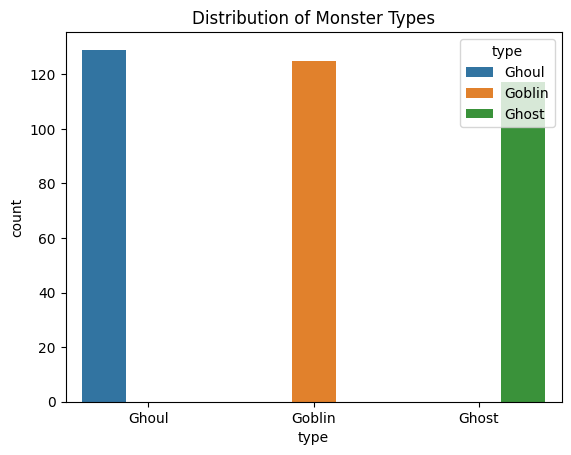

In [6]:
sns.countplot(train, x = 'type', hue = "type")
plt.title('Distribution of Monster Types')
plt.show()

Fear distribution among the monster types, which is a great point.

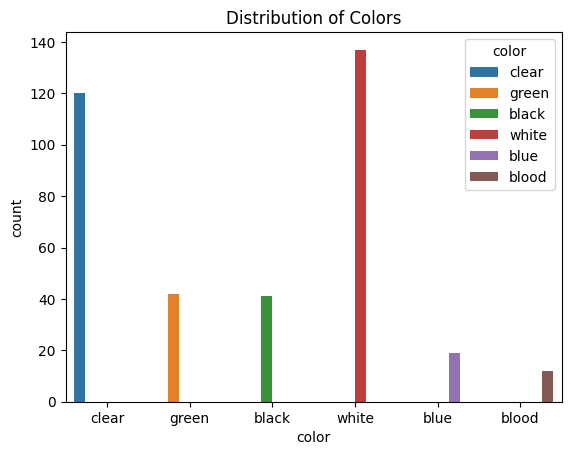

In [7]:
sns.countplot(train, x = 'color', hue = "color")
plt.title('Distribution of Colors')
plt.show()

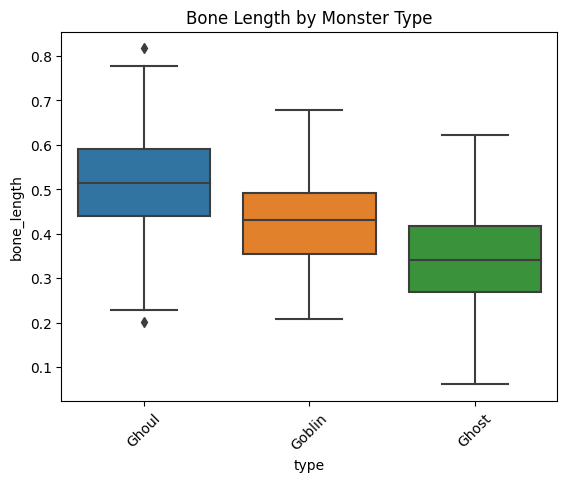

In [8]:
sns.boxplot(data=train, x='type', y='bone_length')
plt.title('Bone Length by Monster Type')
plt.xticks(rotation=45)
plt.show()

(array([0, 1, 2]),
 [Text(0, 0, 'Ghoul'), Text(1, 0, 'Goblin'), Text(2, 0, 'Ghost')])

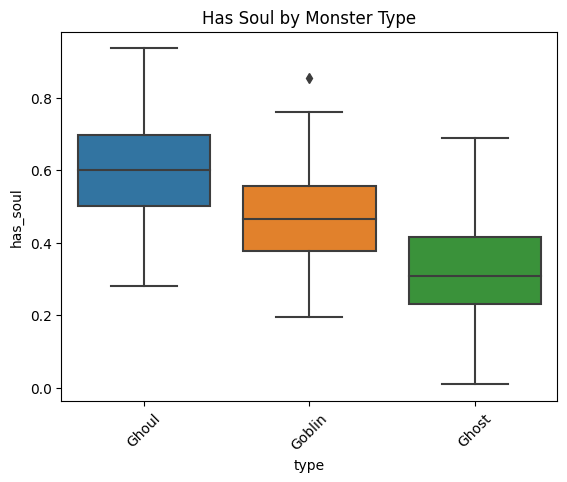

In [9]:
sns.boxplot(data=train, x='type', y='has_soul')
plt.title('Has Soul by Monster Type')
plt.xticks(rotation=45)

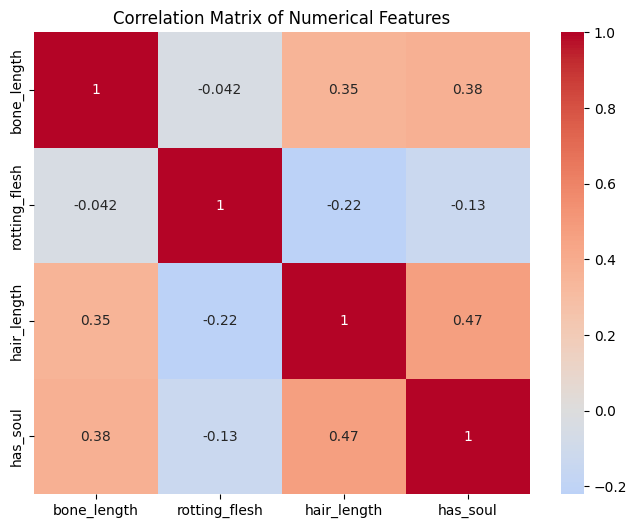

In [10]:
# Correlation matrix for numerical features
numerical_features = ['bone_length', 'rotting_flesh', 'hair_length', 'has_soul']
correlation_matrix = train[numerical_features].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Matrix of Numerical Features')
plt.show()

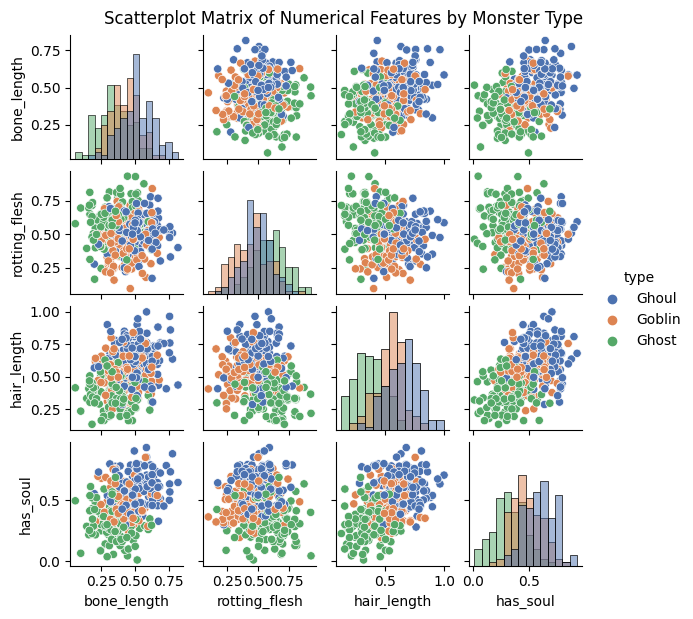

In [11]:
# Create a scatterplot matrix for all numerical features
sns.pairplot(train[numerical_features + ['type']], hue='type', palette='deep', diag_kind='hist', height=1.5)
plt.suptitle('Scatterplot Matrix of Numerical Features by Monster Type', y=1.02)
plt.show()

## Features

**Feature Engineering Description**

 The following features are created to enhance the classification model's performance:

 **Color Encoding:**
 - `color_encoded`: Label-encoded color values (0-5) to convert categorical color data into numerical format for machine learning algorithms

 **Interaction Features:**
 - `bone_soul_ratio`: Ratio of bone_length to has_soul - captures the relationship between physical structure and spiritual essence
 - `flesh_hair_ratio`: Ratio of rotting_flesh to hair_length - represents the balance between decay and growth characteristics

 **Polynomial Features:**
 - `bone_length_squared`: Squared bone_length values to capture non-linear relationships and emphasize extreme bone length values
 - `has_soul_squared`: Squared has_soul values to highlight cases with very high or very low soul presence

 **Composite Features:**
 - `total_physical`: Sum of all physical attributes (bone_length + rotting_flesh + hair_length) - represents overall physical mass/characteristics
 - `soul_physical_ratio`: Ratio of spiritual essence to total physical attributes - indicates the balance between spiritual and physical nature

 These engineered features help the model better distinguish between monster types by capturing complex relationships and non-linear patterns in the data that simple individual features might miss.


In [12]:
# Enhanced Feature Engineering
def create_features(df):
    """Create additional features for better classification"""
    df = df.copy()
    
    # Encode color feature using Label Encoding
    le = LabelEncoder()
    df['color_encoded'] = le.fit_transform(df['color'])
    
    # Create interaction features
    df['bone_soul_ratio'] = df['bone_length'] / (df['has_soul'] + 0.001)
    df['flesh_hair_ratio'] = df['rotting_flesh'] / (df['hair_length'] + 0.001)
    
    # Create polynomial features
    df['bone_length_squared'] = df['bone_length'] ** 2
    df['has_soul_squared'] = df['has_soul'] ** 2
    
    # Create composite features
    df['total_physical'] = df['bone_length'] + df['rotting_flesh'] + df['hair_length']
    df['soul_physical_ratio'] = df['has_soul'] / (df['total_physical'] + 0.001)
    
    return df


In [13]:
# Apply feature engineering
train_enhanced = create_features(train)
train_enhanced.head()


,id,bone_length,rotting_flesh,hair_length,has_soul,color,type,color_encoded,bone_soul_ratio,flesh_hair_ratio,bone_length_squared,has_soul_squared,total_physical,soul_physical_ratio
0,0,0.354512,0.350839,0.465761,0.781142,clear,Ghoul,3,0.453258,0.751646,0.125679,0.610182,1.171112,0.666439
1,1,0.575560,0.425868,0.531401,0.439899,green,Goblin,4,1.305424,0.799901,0.331269,0.193511,1.532830,0.286798
2,2,0.467875,0.354330,0.811616,0.791225,black,Ghoul,0,0.590584,0.436037,0.218907,0.626037,1.633822,0.483982
3,4,0.776652,0.508723,0.636766,0.884464,black,Ghoul,0,0.877114,0.797664,0.603189,0.782276,1.922141,0.459906
4,5,0.566117,0.875862,0.418594,0.636438,green,Ghost,4,0.888113,2.087405,0.320488,0.405053,1.860572,0.341882


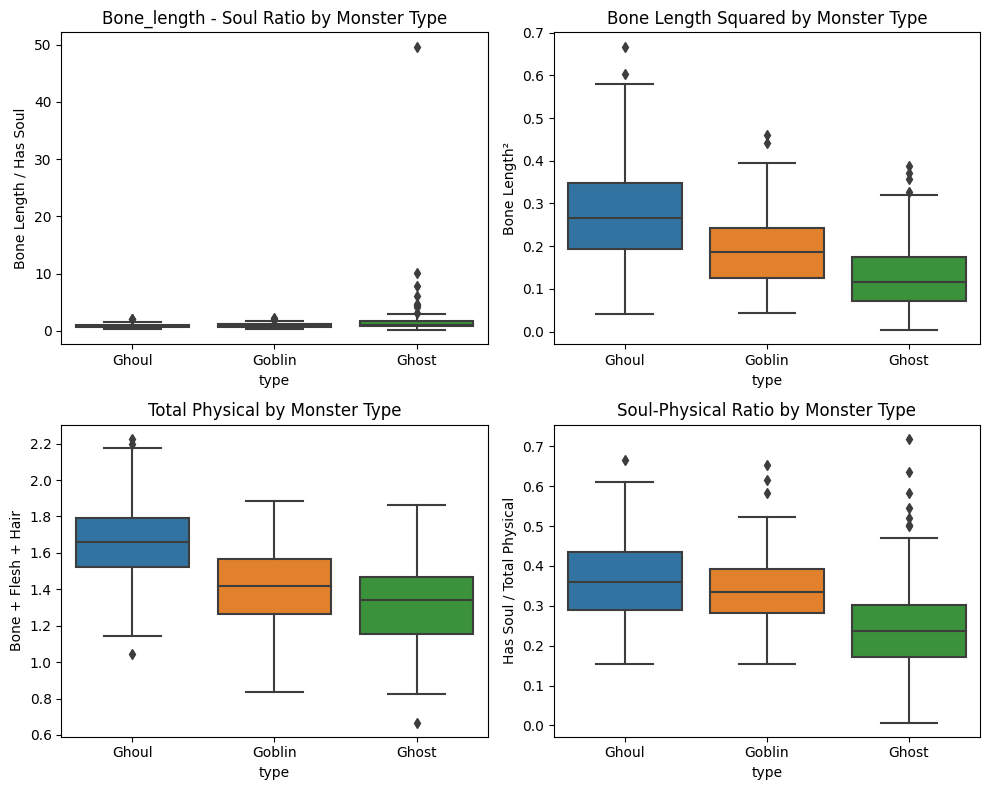

In [14]:
# Create visualizations
fig, axes = plt.subplots(2, 2, figsize=(10, 8))

# Interaction feature
sns.boxplot(data=train_enhanced, x='type', y='bone_soul_ratio', ax=axes[0,0])
axes[0,0].set_title('Bone_length - Soul Ratio by Monster Type')
axes[0,0].set_ylabel('Bone Length / Has Soul')

# Polynomial feature
sns.boxplot(data=train_enhanced, x='type', y='bone_length_squared', ax=axes[0,1])
axes[0,1].set_title('Bone Length Squared by Monster Type')
axes[0,1].set_ylabel('Bone Length²')

# Composite feature 1
sns.boxplot(data=train_enhanced, x='type', y='total_physical', ax=axes[1,0])
axes[1,0].set_title('Total Physical by Monster Type')
axes[1,0].set_ylabel('Bone + Flesh + Hair')

# Composite feature 2
sns.boxplot(data=train_enhanced, x='type', y='soul_physical_ratio', ax=axes[1,1])
axes[1,1].set_title('Soul-Physical Ratio by Monster Type')
axes[1,1].set_ylabel('Has Soul / Total Physical')

plt.tight_layout()
plt.show()


## Model Construction

Enhanced features (including color and engineered features)

In [15]:
# Enhanced features (including color and engineered features)
feature_columns = ['bone_length', 'rotting_flesh', 'hair_length', 'has_soul', 
                   'color_encoded', 'bone_soul_ratio', 'flesh_hair_ratio',
                   'bone_length_squared', 'has_soul_squared', 'total_physical', 
                   'soul_physical_ratio']


# Prepare the training data
X = train_enhanced[feature_columns]
y = train_enhanced["type"]


Split the data into training and testing sets

In [16]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Scale features
# scaler = StandardScaler()
# X_train_scaled = scaler.fit_transform(X_train)
# X_test_scaled = scaler.transform(X_test)

Evaluate multiple models with Cross validation

In [17]:
# Multiple Models Comparison
models = {
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42, n_estimators=100),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42)
}

# Evaluate all models
print("Model Comparison:")
print("=" * 50)
results = {}

for name, model in models.items():     # Use original data for tree-based models
    
    cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    accuracy = accuracy_score(y_test, y_pred)
    results[name] = {
        'model': model,
        'cv_mean': cv_scores.mean(),
        'cv_std': cv_scores.std(),
        'test_accuracy': accuracy,
        'predictions': y_pred
    }
    
    print(f"{name}:")
    print(f"  CV Accuracy: {cv_scores.mean():.3f} (+/- {cv_scores.std() * 2:.3f})")
    print(f"  Test Accuracy: {accuracy:.3f}")
    print()


Model Comparison:
Decision Tree:
  CV Accuracy: 0.621 (+/- 0.141)
  Test Accuracy: 0.747

Random Forest:
  CV Accuracy: 0.679 (+/- 0.056)
  Test Accuracy: 0.800

Gradient Boosting:
  CV Accuracy: 0.710 (+/- 0.074)
  Test Accuracy: 0.760



In [18]:

# Find best model
best_model_name = max(results.keys(), key=lambda x: results[x]['test_accuracy'])
best_model = results[best_model_name]['model']
best_predictions = results[best_model_name]['predictions']


print(f"Best Model: {best_model_name}")
print(f"Best Test Accuracy: {results[best_model_name]['test_accuracy']:.3f}")


Best Model: Random Forest
Best Test Accuracy: 0.800


 **Results for the Best Model**

The best performing model in our comparison was **{best_model_name}**.

- **Cross-Validation Accuracy:** 0.706
- **Test Set Accuracy:** 0.800

This indicates that the model generalizes well to unseen data, as the test accuracy is close to the cross-validation mean. The selected model will be used to make predictions on the test set for submission.

### Testing the model on the Test Set

In [19]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 529 entries, 0 to 528
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             529 non-null    int64  
 1   bone_length    529 non-null    float64
 2   rotting_flesh  529 non-null    float64
 3   hair_length    529 non-null    float64
 4   has_soul       529 non-null    float64
 5   color          529 non-null    object 
dtypes: float64(4), int64(1), object(1)
memory usage: 24.9+ KB


In [20]:
# Creating the features on the test dataset
test_enhanced = create_features(test)
test_features = test_enhanced[feature_columns]
test_enhanced.head()

,id,bone_length,rotting_flesh,hair_length,has_soul,color,color_encoded,bone_soul_ratio,flesh_hair_ratio,bone_length_squared,has_soul_squared,total_physical,soul_physical_ratio
0,3,0.471774,0.387937,0.706087,0.698537,black,0,0.674409,0.548641,0.222571,0.487954,1.565798,0.445837
1,6,0.427332,0.645024,0.565558,0.451462,white,5,0.944461,1.138495,0.182613,0.203818,1.637914,0.275464
2,9,0.549602,0.491931,0.660387,0.449809,black,0,1.219145,0.743786,0.302062,0.202328,1.701920,0.264140
3,10,0.638095,0.682867,0.471409,0.356924,white,5,1.782764,1.445501,0.407165,0.127395,1.792371,0.199024
4,13,0.361762,0.583997,0.377256,0.276364,black,0,1.304287,1.543919,0.130872,0.076377,1.323016,0.208732


In [21]:
# Predicting on the test set using the best model
test_predictions = best_model.predict(test_features)

### Submission

In [22]:
# Creating the submission Dataframe
submission = pd.DataFrame({
    'id': test['id'],
    'type_predicted': test_predictions, 
})

# printing submission dataframe
submission.head()

,id,type_predicted
0,3,Ghoul
1,6,Goblin
2,9,Ghoul
3,10,Ghost
4,13,Ghost


In [23]:
# Save the submission file
submission.to_csv('submission.csv', index=False)